# Computer Assignment 2, by Group 2
Ali Bemani

Oscar Bautista Gonzalez

Martin Hellkvist

## Summary of results
The implementations of GD, SGD, SVRG and SAG are all working fine.
### Stepsize
Comprehensive summary of choice of stepsize as a function of $L$ ($\lambda=0.01$):
* $\alpha= \dfrac{1}{L}$ (See Figure 1):
    * GD: Converges. Goes beneath 0.25 around 500 iterations. Continues to decrease to end cost approximately 0.24 after 20000 iterations.
    * SGD: Large variance in gradients estimates, difficult to determine convergence.
    * SVRG: Same as for SGD.
    * SAG: Has a lower noise component by that the algorithm decreases the variance of the gradient estimates. The noise appears as a slow fluctuation over the iterations, as opposed to SGD and SVRG, where the noise has abrupt jumps between each iteration. Here we could implement some nice stop criterion to stop at a low point in the cost.
* $\alpha= \dfrac{1}{16L}$ (See Figure 2):
    * GD: Converges. Cost beneath 0.26 around 500 iterations. Continues to decrease, cost very close to of 0.25 after 20000 iterations.
    * SGD: The envelope of the cost follows the cost of GD, but has some noise on top of it due to variance in the gradient estimates.
    * SVRG: Similiar to SGD, but the noise seems slightly lower (to the eye).
    * SAG: The slow oscillatory behviour is still present, but the variation is slower over the iterations. The magnitude of the oscillations are unchanged.
    
For GD there seems to be no gain in decreasing the step size.
For SGD and SVRG, the noise level of the cost is much decreased by the lower step size.
The gain for SAG of decreasing the step size was that the oscillations were slower, we do not notice any major effect on the convergence.

### Regularization
With a larger regularization coefficient of $\lambda=10$, the overall convergence behaviour is the same for the two step size.
The main difference is for GD, which converges to its end cost around iteration 500. 
The end cost is higher for a larger $\lambda$, thus the cost level that SGD and SVRG varies about is higher.

### Time consumption
We measured the consumed time for the 4 different methods. In Figure 3 there is a plot with the time consumed versus the number of iterations.
From slowest to quickest, the methods are (and their consumed time for 500 iterations):
1. GD    (1051.0 ms)
2. SAG   (68.8 ms)
3. SVRG  (21.9 ms)
4. SGD   (15.0 ms)

We conclude that GD is much slower than the other methods.
### Hyperparameter tuning
Because we can compute the smoothness $L$, and setting the stepsize to $1/L$, it is very simple to get GD up and running.
For SGD and SVRG, it seems that we need to have another scaling on $L$ to get low variance in the gradient estimates.

In our experiments we used only 10000 datapoints for training and testing. 
Increasing this number to say 100000, makes the runtime of the methods slow, and finding a good stepsize will take more time for SGD and SVRG.

The SAG method worked well for both step sizes $1/L$ and $1/(16L)$.

### Memory usage
To see the memory usage with "resource" package, one needs to run this notebook on a linux machine. For example google colab, if you are not running Linux locally.
We ran the methods in the following order: SGD; SAG; SVRG; GD. 
The memory used by the session during the run of each method was:
* SGD: 
    * 813.318144 mb
* SAG: 
    * 823.525376 mb
* SVRG:
    * 827.850752 mb
* GD:
    * 828.932096 mb
    
We conclude that running SGD can use around 10 megabytes of memory less than the other three methods.

### Stop condition
We do not make use of the stop condition $\varepsilon$ because we investigate both the short- and long term behviour of the methods.

## Implementation

In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
import sys
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace


# the "resource" library is not available on windows. 
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource
    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package")

Failed on importing 'resource' package


### Load the data:
We first load the data into ghgdata. We will only use 10000 data points in this implementation, so its enough to use 70 files.

In [2]:
N_sites = 70
N_cols = 327
dghg = 15
Nghg = N_sites * N_cols
ghgdata = np.zeros((dghg+1, Nghg))

pathprefix = "./Data/ghg_data/ghg_data/ghg.gid.site"
for i in range(N_sites):
    filename = pathprefix + str(i + 1).zfill(4) + ".dat"
    subdata = np.genfromtxt(filename, delimiter=" ")
    ghgdata[:,i*N_cols:(i+1)*N_cols] = subdata

ghgdata = ghgdata.T

### Define function to find the smoothness $L$ of the cost function, given a dataset:
We have that for $L$ to guarantee L-smoothness of $f(w)$, it must fulfill the following inequality:
$$ L \succcurlyeq \frac{1}{4N} \sum_i y_i^2 x_i x_i^T + 2\lambda  $$
$$  = \frac{1}{4N} Z^T Z +2\lambda, $$
$$ Z = \begin{bmatrix}y_1 x_1^T \\ \vdots\\ y_N x_N^T\end{bmatrix}.$$

Which is equivalent to $L \geq \frac{1}{4N}\lambda_{\max}(Z^T Z) + 2\lambda $, where $\lambda_{\max}(Z^T Z)$ is the largest eigenvalue of $Z^T Z$.

We implement the finding of the smallest $L$ in the function ``find_smoothness()``.

In [3]:
def find_smoothness(X, Y, lambda_):
    # finds smallest L to guarantee L-smoothness of the Logistic Ridge Regression, given data X, Y
    # we have found it analytically as the largest eigenvalue of (1/(4N)) * Z.T @ Z + 2 * lambda.
    
    N, d = X.shape
    assert Y.shape == (N,1)
    
    YX = Y * X
    Z = YX.T @ YX
    eigs, _ = np.linalg.eig((1/(4*N))*Z)
    L = np.max(eigs) + 2*lambda_
    
    return L

### Preprocessing of data...

### Preprocessing of the response variable
We use the first 15 variables of the data as inputs $x_i$, and the 16th row as output.
We found that using the raw output data came with some numerical issues, due to the products $y_i x_i$ being very large quite often.
We therefore threshold the output data into a binary variable in $\{-1,+1\}$.

We here load the ``ghgdata`` into ``X`` and ``Y`` matrices, and perform the thresholding on the ``Y`` matrix.

The plots show histograms of ``Y`` before and after thresholding.

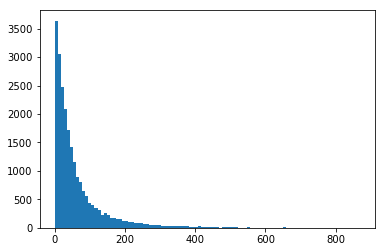

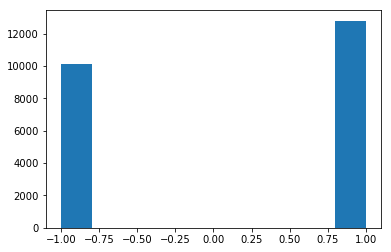

In [4]:
X = ghgdata[:, 0:dghg]
Y = ghgdata[:, [dghg]]
plt.figure(1)
_ = plt.hist(Y, bins=100)

# threshold Y to binary
threshold = 30
mask = Y < threshold
Y[mask] = -1
Y[~mask] = 1
plt.figure(2)
_ = plt.hist(Y)

### Split data into training and testing datasets
We are not really interested in finding a good classifier of the data, but only to verify our implementation of GD, SGD, SVRG and SAG.
Therefore we limit the simulations to only 10000 datapoints for training, to decrease the run time. We use 1000 data points for testing.

In [5]:
# Split train and test data here: (X_train, Y_train, X_test, Y_test)
N_train = 10000
N_test = 1000

# train_idx = np.random.choice(Nghg, size=N_train, replace=False)
train_idx = np.arange(N_train)
X_train = X[train_idx, :]
Y_train = Y[train_idx]

# test_idx_bool = ~np.isin(np.arange(Nghg), train_idx)
test_idx = np.arange(N_train, N_train + N_test)
X_test = X[test_idx, :]
Y_test = Y[test_idx]

## Implementing Cost and Gradient functions
#### The logistic ridge regression
$$ f(x) = \frac{1}{N}\sum_{i\in[N]} f_i(x) + \lambda\lVert w \rVert_2^2 $$
has the gradient: 
$$ \nabla f(x) = \frac{1}{N}\sum_{i\in[N]} \nabla f_i(x) + 2\lambda w, $$
$$ \nabla f_i(x) = -y_i x_i \frac{e^{-y_ix_i^T w}}{1 + e^{-y_ix_i^T w}} = -y_i x_i \frac{1}{1 + e^{y_i x_i^T w}}.$$
We use the latter form for computing gradients, since it has better numerical stability (the exponent can take "inf" values, thus the former form is undefined, while the latter is identically zero).

We define the gradient estimate for data point $i$ including regularization as:
$$  \hat{g}_i(w) = \nabla f_i(w) + 2\lambda w.$$

The ``cost()`` function is an implementation of $f(w)$.
The ``function_gradient()`` is an implementation of $\nabla f(w)$, given ``X, Y`` and ``w``.

In [6]:
def cost(x, y, w, lambda_ = 0.01):
    N, d = x.shape
    value = np.sum(np.log(1 + np.exp(- y*x @ w)))
    norm_w = np.linalg.norm(w)
    c = lambda_ * norm_w ** 2
    return value/N + c 

def function_gradient(X, Y, w, lambda_):
    N, d = X.shape
    assert Y.shape == (N,1)
    assert w.shape == (d,1)
    output = np.zeros((N,1))
    YX = Y * X # (N,d)
    YXw = YX @ w # (N,1)
    exp_vec = 1/(1 + np.exp(YXw)) # (N,1)
    grad_array = -YX * exp_vec # (N,d)
    output = np.sum(grad_array, axis=0) # (1,d)
    output = (1/N) * output.reshape(d,1) + 2 * lambda_ * w # (d,1)
    return output # (d,1)

### Implementing the gradient methods

In [12]:
def solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "GD", mem=False, return_cost=False, verbose=True):
    if (optimizer == "GD"):
        cost_ = np.zeros(num_iters)
        for i in range(num_iters):
            g = function_gradient(x, y, w, lambda_) # compute the exact gradient wrt w, given x and y
            w = w - alpha * g # GD update
            
            if return_cost:
                cost_[i] = cost(X_test, Y_test, w, lambda_)
            
            if (i%10==0) and (mem) and ('resource' in sys.modules) and (verbose):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for GD (mb):", (usage[2]*resource.getpagesize())/1000000.0)
                        
            if (np.linalg.norm(g) <= epsilon):
                print("GD: Stop on condition fulfilled! Number of iterations: ", i+1, "/", num_iters)
                break
        if verbose:
            print("GD: Number of iterations: ", num_iters, "/", num_iters)
            print("GD: final norm: ", np.linalg.norm(g))
                
    elif (optimizer == "SGD"):
        cost_ = np.zeros(num_iters)
        N, d = x.shape
        assert y.shape == (N,1)
        for i in range(num_iters):
            i_ = int(N*np.random.rand(1))
            x_ = x[[i_], :]
            y_ = y[[i_], :]
            
            g = function_gradient(x_, y_, w, lambda_) # compute gradient
            w = w - alpha * g # GD update 
            
            if return_cost:
                cost_[i] = cost(X_test, Y_test, w, lambda_)
            
            if (i%10==0) and (mem) and ('resource' in sys.modules) and (verbose):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for SGD (mb):", (usage[2]*resource.getpagesize())/1000000.0)
                
    elif (optimizer == "SVRG"):
        N, d = x.shape
        assert y.shape == (N,1)
        
        T = 1000 # epoch length
        K = math.floor(num_iters/T) # number of epochs, given number of iterations
        
        if K == 0:
            # only run for one epoch consisting of num_iters iterations
            K = 1
            T = num_iters
        if verbose:
            print("number of epochs: ", K)
        cost_ = np.zeros(T*K)
        
        for k in range(K):
            yx = y * x # (N, d)
            yxw = yx @ w # (N, 1)
            
            assert yx.shape == (N, d)
            assert yxw.shape == (N, 1)
            
            # G_ is equal to using function_gradient, but we need G_vec, so we compute it manually here
            exp_vec = 1/(1 + np.exp(yxw)) # (N, 1)
            
            G_vec = (-yx * exp_vec).reshape(d, N) + 2*lambda_*w # (d, N)
                                    
            G_ = (1/N) * np.sum(G_vec, axis=1, keepdims=1) # (d, 1)
            if (np.linalg.norm(G_) <= epsilon): # check the average gradient
                print("SVRG: Stop on condition fulfilled! Number of iterations: ", k*t, "/", num_iters)
                break
            
            assert G_vec.shape == (d, N)
            assert G_.shape == (d, 1)
            
            for t in range(T):
                i_ = int(N*np.random.rand(1))
                x_ = x[[i_], :] # (1, d)
                y_ = y[[i_], :] # (1, 1)
                g = function_gradient(x_, y_, w, lambda_) # (d, 1)
                assert g.shape == (d,1)
                assert G_vec[:, [i_]].shape == (d,1)
                assert G_.shape == (d,1)
                w = w - alpha*(g - G_vec[:, [i_]] + G_)
                
                if return_cost:
                    cost_[t + k*T] = cost(X_test, Y_test, w, lambda_)
                    
                if (t%10==0) and (mem) and ('resource' in sys.modules) and (verbose):
                    usage=resource.getrusage(resource.RUSAGE_SELF)
                    print("mem for SVRG (mb):", (usage[2]*resource.getpagesize())/1000000.0)
                    
        if (K > 0) and (verbose):
            print("SVRG: final norm: ", np.linalg.norm(g))
            
    elif (optimizer == "SAG"):
        N, d = x.shape
        assert y.shape == (N,1)
        
        # compute initial gradient estimates for all datapoints
        yx = y * x # (N, d)
        yxw = yx @ w # (N, 1)
        exp_vec = 1/(1 + np.exp(yxw)) # (N, 1)
        G_vec = np.zeros((d, N))
        cost_ = np.zeros(num_iters)
        g_avg = np.zeros((d,1))
        for k in range(num_iters):
            i_ = int(N*np.random.rand(1))
            x_ = x[[i_], :] # (1, d)
            y_ = y[[i_], :] # (1, 1)
            g = function_gradient(x_, y_, w, lambda_) # (d, 1)
            g_avg = g_avg - G_vec[:, [i_]] + g
            G_vec[:, [i_]] = g # (d, N)
            w = w - (alpha/N) * g_avg
            if return_cost:
                cost_[k] = cost(X_test, Y_test, w, lambda_)
                
            if (np.linalg.norm(g) <= epsilon):
                    print("SAG: Stop on condition fulfilled! Number of iterations: ", k, "/", num_iters)
                    break
                    
            if (k%10==0) and (mem) and ('resource' in sys.modules) and (verbose):
                    usage=resource.getrusage(resource.RUSAGE_SELF)
                    print("mem for SAG (mb):", (usage[2]*resource.getpagesize())/1000000.0)
        if verbose:
            print("final norm: ", np.linalg.norm(g))
    if return_cost:
        return w, cost_
    else:
        return w

### Setting the constant stepsize
In these implementations we are using constant stepsize.

We set regularization $\lambda=0.01$.

We set the step size as $\alpha=\dfrac{1}{aL}$ where we set $a=16$ to upscale the smoothness factor we found.
If we have $a=1$, i.e., $\alpha=\dfrac{1}{L}$, the gradient estimates found by SGD and SVRG become very noisy.

In [8]:
lambda_ = 0.01
epsilon = 0

Load ``Y_train`` and ``X_train`` into ``y`` and ``x``.
Initial guess ``w``:

In [9]:
y = Y_train
x = X_train
print("x: ", x.shape)
print("y: ", y.shape)
N, d = x.shape
w = np.random.rand(d,1)*0.01  # Initialization of w

x:  (10000, 15)
y:  (10000, 1)


In [10]:
L = find_smoothness(x, y, lambda_)
print("L: ", L)
a = 1
alpha = 1/(a*L)
alpha_string = "alpha = 1/({0}*L)".format(a) + ": "
print(alpha_string, alpha)

L:  4498.793513176702
alpha = 1/(1*L):  0.00022228181779649562


### Trial runs for the methods

In [11]:
#-------------------- GD Solver -----------------------
print(alpha)
num_iters = 1000 # change the value
start = time.time()
gd = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "GD", mem=False)
end = time.time()
print("Weights of GD after convergence: \n", gd.flatten())
cost_value = cost(X_test, Y_test, gd, lambda_) 
print("Cost of GD after convergence: ", cost_value)

print("Training time for GD: ", end-start)

0.00022228181779649562
GD: Number of iterations:  1000 / 1000
GD: final norm:  0.18394461876382295
Weights of GD after convergence: 
 [ 0.00453573  0.00255239 -0.00062067  0.00557415  0.006266    0.00667566
 -0.02119499 -0.0043979  -0.00661011  0.0052753  -0.01824091  0.02136091
 -0.0022253   0.02438812 -0.02650114]
Cost of GD after convergence:  0.24704424701715275
Training time for GD:  5.234012842178345


In [12]:
#-------------------- SGD Solver -----------------------
num_iters = 100 # change the value
start = time.time()
sgd = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "SGD", mem=False)
end = time.time()
print("Weights of SGD after convergence: \n", sgd.flatten())

cost_value = cost(X_test, Y_test, sgd, lambda_)  # Calculate the cost value
print("Cost of SGD after convergence: ", cost_value)

print("Training time for SGD: ", end-start)

Weights of SGD after convergence: 
 [ 0.00472768  0.00466534  0.00420877  0.00619729  0.00651086  0.00673204
  0.00562456  0.0020217   0.00116507  0.0054463   0.00114349  0.02058684
  0.0042722   0.03016426 -0.00253176]
Cost of SGD after convergence:  0.24996271707742423
Training time for SGD:  0.01548457145690918


In [13]:
#-------------------- SVRG Solver -----------------------
num_iters = 10000 # change the value
start = time.time()
svrg = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer="SVRG", mem=False)
end = time.time()
print("\nWeights of SVRG after convergence: \n", svrg.flatten())

cost_value = cost(X_test, Y_test, svrg, lambda_)
print("Cost of SVRG after convergence: ", cost_value)
print("Training time for SVRG: ", end-start)

number of epochs:  10
SVRG: final norm:  4.343510986408538

Weights of SVRG after convergence: 
 [-0.06053231  0.03491096 -0.055736   -0.03119001  0.01503698 -0.04203023
 -0.27251908  0.08760234  0.1468727  -0.06230469  0.00047315  0.04854225
  0.00302259  0.04660175 -0.10251359]
Cost of SVRG after convergence:  0.2669655773441332
Training time for SVRG:  1.2356970310211182


In [ ]:
#-------------------- SAG Solver -----------------------
num_iters = 10000 # change the value
start = time.time()
sag = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer="SAG", mem=False)
end = time.time()
print("Weights of SAG after convergence: \n", sag.flatten())

cost_value = cost(X_test, Y_test, sag, lambda_)
print("Cost of SAG after convergence: ", cost_value)
print("Training time for SAG: ", end-start)

### Here we create the plots interesting for the results
#### The displayed cost is the cost on the test data set X_test, Y_test

In [13]:
## Executing the iterations and plot the cost function here:
a = 1
alpha = 1/(a*L)
alpha_string = "alpha = 1/({0}*L)".format(a) + ": "
print(alpha_string, alpha)

n_sims = 1
I_max = 20000
cost_1= np.zeros((I_max,4))
for n in range(n_sims):
    w = np.random.rand(d,1)*0.01
    
    print("......",n+1,".......")
    #--------------GD-------------------
    gd, gd_cost  = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="GD", mem=False, return_cost=True, verbose=False)

    cost_1[:,0] += gd_cost/n_sims

    #---------------SGD------------------
    sgd, sgd_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SGD", mem=False, return_cost=True, verbose=False)

    cost_1[:,1] += sgd_cost/n_sims
    
    #---------------SVRG----------------
    svrg, svrg_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SVRG", mem=False, return_cost=True, verbose=False)

    cost_1[:,2] += svrg_cost/n_sims
    
    #---------------SAG------------------
    sag, sag_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SAG", mem=False, return_cost=True, verbose=False)
    
    cost_1[:,3] += sag_cost/n_sims
    
    #------------------------------------

alpha = 1/(1*L):  0.00022228181779649562
...... 1 .......


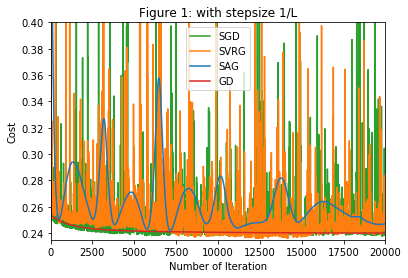

In [15]:
## PLOTs
l1 = plt.plot(cost_1[:,1],color="C2", label='SGD')
l2 = plt.plot(cost_1[:,2],color="C1", label='SVRG')
l3 = plt.plot(cost_1[:,3],color="C0", label='SAG')
l0 = plt.plot(cost_1[:,0],color="C3", label='GD')
# complete other plots here: 

plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend()

plt.ylim(0.235, .4)
plt.xlim(0,20000)
_ = plt.title('Figure 1: with stepsize 1/L')

In [16]:
## Executing the iterations and plot the cost function here:
a = 16
alpha = 1/(a*L)
alpha_string = "alpha = 1/({0}*L)".format(a) + ": "
print(alpha_string, alpha)

n_sims = 1
I_max = 20000
ti= np.zeros((I_max,4))
cost_2= np.zeros((I_max,4))
for n in range(n_sims):
    w = np.random.rand(d,1)*0.01
    
    print("......",n+1,".......")
    #--------------GD-------------------
    gd, gd_cost  = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="GD", mem=False, return_cost=True, verbose=False)

    cost_2[:,0] += gd_cost/n_sims

    #---------------SGD------------------
    sgd, sgd_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SGD", mem=False, return_cost=True, verbose=False)

    cost_2[:,1] += sgd_cost/n_sims
    
    #---------------SVRG----------------
    svrg, svrg_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SVRG", mem=False, return_cost=True, verbose=False)

    cost_2[:,2] += svrg_cost/n_sims
    
    #---------------SAG------------------
    sag, sag_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SAG", mem=False, return_cost=True, verbose=False)
    
    cost_2[:,3] += sag_cost/n_sims
    
    #------------------------------------

alpha = 1/(16*L):  1.3892613612280977e-05
...... 1 .......


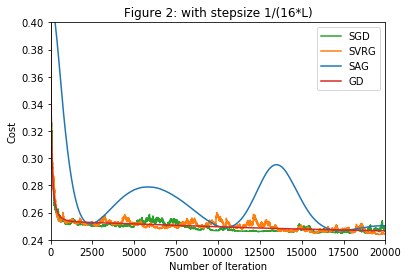

In [18]:
## PLOTs
l1 = plt.plot(cost_2[:,1], color="C2", label='SGD')
l2 = plt.plot(cost_2[:,2], color="C1", label='SVRG')
l3 = plt.plot(cost_2[:,3], color="C0", label='SAG')
l0 = plt.plot(cost_2[:,0], color="C3", label='GD')
# complete other plots here: 

plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend()

plt.ylim(0.24, .4)
plt.xlim(0, 20000)
_ = plt.title('Figure 2: with stepsize 1/(16*L)')

In [ ]:
## Executing the iterations and plot the cost function here:
I_max = 500
ti= np.zeros((I_max,4))
cost_= np.zeros((I_max,4))
w = np.random.rand(d,1)*0.01
for i in range(I_max):
    print("......",i,".......")
    #--------------GD-------------------
    start = time.time()
    gd = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="GD", mem=False)
    end = time.time()

    cost_[i,0] = cost(X_test, Y_test, gd, lambda_)

    ti[i,0] = end-start

    #---------------SGD------------------
    start = time.time()
    sgd = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SGD", mem=False)
    end = time.time()

    cost_[i,1] = cost(X_test, Y_test, sgd, lambda_)

    ti[i,1] = end-start
    
    #---------------SVRG----------------
    start = time.time()
    svrg = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SVRG", mem=False)
    end = time.time()

    cost_[i,2] = cost(X_test, Y_test, svrg, lambda_)

    ti[i,2] = end-start
    
    #---------------SAG------------------
    start = time.time()
    sag = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SAG", mem=False)
    end = time.time()

    cost_[i,3] = cost(X_test, Y_test, sag, lambda_)

    ti[i,3] = end-start
    
    #------------------------------------
    
    ## Pl the results:
    

In [ ]:
l0 = plt.plot(ti[:,0],color="C3",label="GD")
l1 = plt.plot(ti[:,1],color="C2",label="SGD")
l2 = plt.plot(ti[:,2],color="C1",label="SVRG")
l3 = plt.plot(ti[:,3],color="C0",label="SAG")
# complete other plots here:

plt.xlabel("Number of Iteration")
plt.ylabel("Time (sec)")
plt.legend()
_ = plt.title('Figure 3: Time per nubmer of iterations.')

print(ti[-1,:])